<a href="https://colab.research.google.com/github/kpjaskie/Education/blob/main/Introduction_to_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Introduction

&#169; *Kristen Jaskie, Feb 2022*

In this notebook, we will be using Neural Networks to solve simple classification problems using both sklearn and tensorflow.  The simple networks we will be using are sometimes called multi-layer preceptrons, or MLPs. MLPs are shallow neural networks (as opposed to deep learning networks), meaning that they usually only have a couple of hidden layers rather than many layers and filters, as in deep learning.  

These networks generally have the following structure:


![picture](https://www.tutorialspoint.com/tensorflow/images/multi_layer_perceptron.jpg)

Mathematically, this can be shown by:

![picture](https://scikit-learn.org/stable/_images/multilayerperceptron_network.png)

In [1]:
# First, we need to import the relavent libraries

# General libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

# For creating an MLP manually
from sklearn.neural_network import MLPClassifier

# For creating an MLP using Tensorflow
import tensorflow as tf

# To create confusion matrices and metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import seaborn as sns; sns.set()  # for plotting confusion matrices
from tabulate import tabulate

# Load Data
We're going to use the MNIST dataset for these excercises as it is standard for introducing classification.

In [2]:
#We can get MNIST from tensorflow
mnist = tf.keras.datasets.mnist

#Load data set
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
#@title Select Classes
Positive_class = '3' #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
Negative_class = '5' #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
assert (Positive_class is not Negative_class), \
          "Positive and negative sets must be different"

digit_P = int(Positive_class)
digit_N = int(Negative_class)

#isolate desired digits
X_train_P = x_train[y_train == digit_P,:,:]
X_train_N = x_train[y_train == digit_N,:,:]

X_test_P = x_test[y_test == digit_P,:,:]
X_test_N = x_test[y_test == digit_N,:,:]

#normalize data so all values are between 0 and 1
X_train_P = X_train_P / 255 
X_train_N = X_train_N / 255
X_test_P = X_test_P / 255 
X_test_N = X_test_N / 255

# Display Data


Classifying  3  verses  5

Shape of original dataset X:  (60000, 28, 28)
Shape of original labels y:  (60000,)

Training Data:
X_Positive:  (6131, 28, 28)
X_Negative:  (5421, 28, 28)

Testing Data:
X_Positive:  (1010, 28, 28)
X_Negative:  (892, 28, 28)

Some images from the positive and negative sets: 


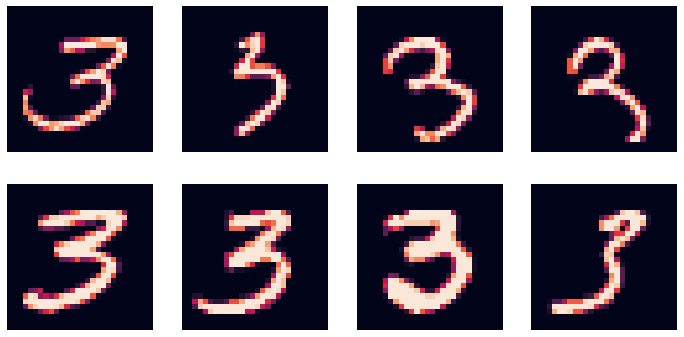

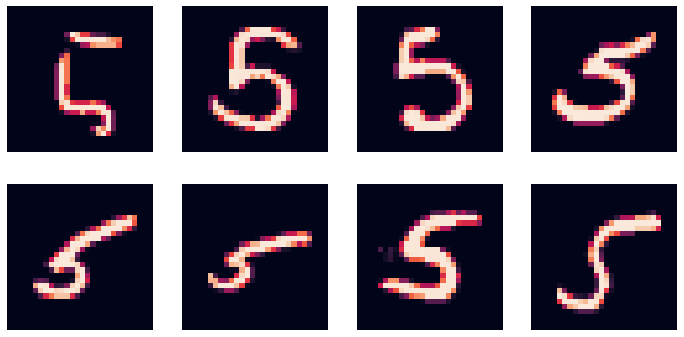

In [4]:
print("\nClassifying ", digit_P, " verses ", digit_N)
print("\nShape of original dataset X: ", x_train.shape)
print("Shape of original labels y: ", y_train.shape)

print('\nTraining Data:')
print("X_Positive: ", X_train_P.shape)
print("X_Negative: ", X_train_N.shape)
print('\nTesting Data:')
print("X_Positive: ", X_test_P.shape)
print("X_Negative: ", X_test_N.shape)

def show_MNIST_images(images):
  # visualize random 2x4 subset of images
  nrows = 2
  ncols = 4

  # Set up matplotlib fig, and size it to fit 
  fig = plt.gcf()
  fig.set_size_inches(ncols * 3, nrows * 3)

  # choose random images to display
  for i in range(nrows * ncols):
    pic_index = random.randint(0, len(images)-1)
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    plt.imshow(images[pic_index])

  plt.show()

print("\nSome images from the positive and negative sets: ")
show_MNIST_images(X_train_P)
show_MNIST_images(X_train_N)

# Combine and Flatten Dataset
The data needs to be flattened so that each digit is represened by a single 28x28 = 784 long array for classification, and then both digits combined into a single dataset and shuffled, for both the training and testing sets.

In [5]:
X_train_P_flat = X_train_P.reshape(X_train_P.shape[0], X_train_P.shape[1]*X_train_P.shape[2])
X_train_N_flat = X_train_N.reshape(X_train_N.shape[0], X_train_N.shape[1]*X_train_N.shape[2])

X_test_P_flat = X_test_P.reshape(X_test_P.shape[0], X_test_P.shape[1]*X_test_P.shape[2])
X_test_N_flat = X_test_N.reshape(X_test_N.shape[0], X_test_N.shape[1]*X_test_N.shape[2])

print('Training Data:')
print("X_Positive flattened: ", X_train_P_flat.shape)
print("X_Negative flattened: ", X_train_N_flat.shape)
print('\nTesting Data:')
print("X_Positive flattened: ", X_test_P_flat.shape)
print("X_Negative flattened: ", X_test_N_flat.shape)

Training Data:
X_Positive flattened:  (6131, 784)
X_Negative flattened:  (5421, 784)

Testing Data:
X_Positive flattened:  (1010, 784)
X_Negative flattened:  (892, 784)


In [6]:
# Combine training and testing data into datasets
X_train_val = np.concatenate((X_train_P_flat, X_train_N_flat))
X_test = np.concatenate((X_test_P_flat, X_test_N_flat))

# Create y vectors out of ones and zeros to match positive and negatives in data
y_train_val = np.concatenate((np.ones((X_train_P.shape[0], 1)), np.zeros((X_train_N.shape[0],1))))
y_test = np.concatenate((np.ones((X_test_P.shape[0], 1)), np.zeros((X_test_N.shape[0],1))))

# Shuffle data and labels in sync
shuffle_order_train = np.random.permutation(X_train_val.shape[0])
X_train_val = X_train_val[shuffle_order_train,:]
y_train_val = y_train_val[shuffle_order_train,]

shuffle_order_test = np.random.permutation(X_test.shape[0])
X_test = X_test[shuffle_order_test,:]
y_test = y_test[shuffle_order_test,]

# Print sizes to confirm correct
print('Training and Validation Data:')
print("X_train_val: ", X_train_val.shape)
print("y_train_val: ", y_train_val.shape)
print('\nTesting Data:')
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

Training and Validation Data:
X_train_val:  (11552, 784)
y_train_val:  (11552, 1)

Testing Data:
X_test:  (1902, 784)
y_test:  (1902, 1)


# Split into Train/Validation/Test Sets
We're going to reserve the test data for final testing and split our training data into training and validation sets

In [7]:
#Here, our training set is composed of 70% of the training data and our validation
#set is 30% of the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.7)

# Sklearn

We're going to create an MLP using Sklearn.  We're definitely going to have to do some hyperparameter tuning on this - neural nets have more hyperparameters than most other methods.

Here, our hyperparameters consist of:
* The number of hidden layers
* The number of hidden nodes in each hidden layer
* The activation function which can be ‘identity’, ‘logistic’, ‘tanh’, or ‘relu’ ('relu' is fairly standard).  See the documentation for more details.
* The type of solver which can be ‘lbfgs’, ‘sgd’, or ‘adam’.  'sgd' is standard gradiant descent, while 'adam' is a specialized version of gradient descent ('adam' is fairly standard)
* The max_iter specifies the maximum number of iterations.

The following code automatically tests a variety of hidden layers and hidden nodes though it uses the standard 'relu' activation function and 'adam' solver.  Feel free to play with these as well.

If you want to see more options, take a look at the documentation:

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlp#sklearn.neural_network.MLPClassifier

In [8]:
#@title Tune Hyperparameters and Train Network

#@markdown Set the hidden layers and hidden nodes in the code
Activation = 'relu' #@param ["relu", "identity", "logistic", "tanh"]
Solver = 'adam' #@param ["adam","lbfgs", "sgd"]
Maximum_Iterations = 1000 #@param {type:"slider", min:0, max:10000, step:100}

# The number of nodes in each hidden layer is specified in this first field
# Each additional layer is then specified 
NN_classify_model = MLPClassifier(hidden_layer_sizes=(20,10), 
                                     activation=Activation, 
                                     solver=Solver, 
                                     max_iter=Maximum_Iterations)


NN_classify_model.fit(X_train, y_train)
y_hat_train = NN_classify_model.predict(X_train)
y_hat_val = NN_classify_model.predict(X_val)

train_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_val, y_hat_val)
print('Training Accuracy: ', train_accuracy)
print('Validation Accuracy: ', val_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy:  1.0
Validation Accuracy:  0.9818226783726969


In [10]:
#@title Test Final Model Performance on test data

NN_classify_model.fit(X_train_val, y_train_val) #train on ALL data
y_hat_test = NN_classify_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_hat_test)
print('Final Test Accuracy: ', test_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Final Test Accuracy:  0.9915878023133544


Metric     Value
---------  -------
Accuracy   0.992
Precision  0.992
Recall     0.992
F-score    0.992



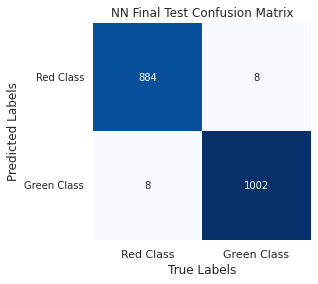

In [11]:
#@title Evaluate Final Model

accuracy_nn_final = round(accuracy_score(y_test, y_hat_test), 3)
precision_nn_final = round(precision_score(y_test, y_hat_test), 3)
recall_nn_final = round(recall_score(y_test, y_hat_test), 3)
fscore_nn_final = round(f1_score(y_test, y_hat_test), 3)

print(tabulate([['Accuracy', accuracy_nn_final], 
                ['Precision', precision_nn_final],
                ['Recall', recall_nn_final],
                ['F-score', fscore_nn_final],
                [' ', ' ']], 
               headers=['Metric', 'Value']))

CM_nn = confusion_matrix(y_test, y_hat_test)

ax = sns.heatmap(CM_nn.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Red Class','Green Class'))
ax.set_yticklabels(('Red Class','Green Class'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("NN Final Test Confusion Matrix")
plt.show()

# Tensorflow

Here, we're going to do the same as above, just using tensorflow instead of sklearn.

In [16]:
#@title Design our MLP Neural Network

# Create a neural net in tensorflow using keras
neural_net = tf.keras.Sequential()

# Remember how the images were 28x28?  Here tensorflow can do the flattening for us
# neural_net.add(tf.keras.layers.Flatten(input_shape=(28,28)))
# However, since our data is already flattened, we're going to use that
neural_net.add(tf.keras.layers.Input(28*28,))

# As before, we can add hidden layers with however many neurons we want in each
neural_net.add(tf.keras.layers.Dense(3, activation='relu'))
neural_net.add(tf.keras.layers.Dense(3, activation='relu'))

# As we're performing binary classification, our output neuron should be a sigmoid
neural_net.add(tf.keras.layers.Dense(1, activation='sigmoid'))
neural_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 2355      
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 2,371
Trainable params: 2,371
Non-trainable params: 0
_________________________________________________________________


In [17]:
#@title Train our MLP

#@markdown As before, set hyperparameters
Solver = 'adam' #@param ["adam","lbfgs", "sgd"]
Loss = 'binary_crossentropy' #@param ["binary_crossentropy"]
Metrics = 'acc' #@param ["acc"]
Epochs = 10 #@param {type:"slider", min:0, max:100, step:1}

neural_net.compile(Solver,loss=Loss,metrics=['acc'])
model_history = neural_net.fit(X_train, y_train, 
                               validation_split=0.4,
                               batch_size=32, epochs=Epochs)

Epoch 1/10
65/65 [==============================] - 1s 5ms/step - loss: 0.6495 - acc: 0.5455 - val_loss: 0.6006 - val_acc: 0.5642
Epoch 2/10
65/65 [==============================] - 0s 3ms/step - loss: 0.5596 - acc: 0.6272 - val_loss: 0.5132 - val_acc: 0.7100
Epoch 3/10
65/65 [==============================] - 0s 3ms/step - loss: 0.4809 - acc: 0.7629 - val_loss: 0.4405 - val_acc: 0.8095
Epoch 4/10
65/65 [==============================] - 0s 3ms/step - loss: 0.4184 - acc: 0.8523 - val_loss: 0.3892 - val_acc: 0.8968
Epoch 5/10
65/65 [==============================] - 0s 3ms/step - loss: 0.3744 - acc: 0.8995 - val_loss: 0.3558 - val_acc: 0.9221
Epoch 6/10
65/65 [==============================] - 0s 3ms/step - loss: 0.3446 - acc: 0.9240 - val_loss: 0.3328 - val_acc: 0.9372
Epoch 7/10
65/65 [==============================] - 0s 3ms/step - loss: 0.3233 - acc: 0.9365 - val_loss: 0.3147 - val_acc: 0.9466
Epoch 8/10
65/65 [==============================] - 0s 3ms/step - loss: 0.3032 - acc: 0.94

<Figure size 432x288 with 0 Axes>

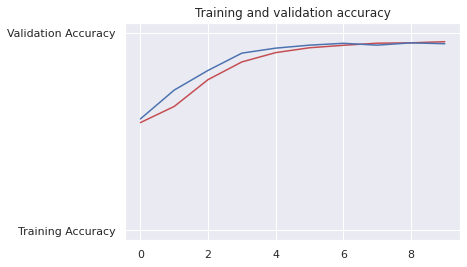

<Figure size 432x288 with 0 Axes>

In [18]:
#@title Plot training and validation accuracy
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=model_history.history['acc']
val_acc=model_history.history['val_acc']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [19]:
#@title Test Final Model Performance on test data
model_history = neural_net.fit(X_test, y_test, 
                               batch_size=32, epochs=Epochs)

Epoch 1/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2662 - acc: 0.9585
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2501 - acc: 0.9627
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2380 - acc: 0.9648
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2251 - acc: 0.9700
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2147 - acc: 0.9711
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.2050 - acc: 0.9737
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1960 - acc: 0.9779
Epoch 8/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1871 - acc: 0.9748
Epoch 9/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1791 - acc: 0.9779
Epoch 10/10
60/60 [==============================] - 0s 2ms/step - loss: 0.1716 - acc: 0.9800


# Multiclass classification
It's just as easy to classify all digits against one another, as it is to compare two images.  Most of the work above was to isolate two images and perform data manipulation to get the datasets in the shape and format that we wanted them in.

To do multiclass classification, the final network layer should have ten neurons to represent the ten digits:

> neural_net.add(tf.keras.layers.Dense(10, activation='softmax'))

And the training code should include the categorical_crossentropy rather than the binary_crossentropy and look like:

* neural_net.compile('adam', loss='categorical_crossentropy',metrics=['accuracy'])
* num_classes = 10
* y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
* y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)



Your turn!